In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.time import Time
from astropy.timeseries import LombScargle
import exoplanet as xo
import celerite
from celerite import terms
from scipy.optimize import minimize

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
file = 'aavsodata_5f20eb1154bf8.txt'
df = pd.read_csv(file)
# df

/Users/james/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,15,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.columns

Index(['JD', 'Magnitude', 'Uncertainty', 'HQuncertainty', 'Band',
       'Observer Code', 'Comment Code(s)', 'Comp Star 1', 'Comp Star 2',
       'Charts', 'Comments', 'Transfomed', 'Airmass', 'Validation Flag',
       'Cmag', 'Kmag', 'HJD', 'Star Name', 'Observer Affiliation',
       'Measurement Method', 'Grouping Method', 'ADS Reference', 'Digitizer',
       'Credit'],
      dtype='object')

In [5]:
vok = np.where((df['Uncertainty'] < 0.1) &          # select only "good" data
               (df['Band'] == 'V') &                # in V band
               (df['JD'] > (2459059.6638 - 40*365)) # within last ~40yrs
              )[0]

np.size(vok) # how many data points do we have?

1579

In [6]:
# manually add data from the STEREO ATel
new_dates = Time(['2020-06-24', '2020-7-13', '2020-07-20'], format='isot', scale='utc')
new_mags = [0.66, 0.76, 0.80]
new_errs = [0.015, 0.015, 0.015]

In [7]:
time = Time(df['JD'].values[vok], format='jd')

XX = time.to_value('decimalyear')
YY = df['Magnitude'][vok].astype('float').values
EE = df['Uncertainty'][vok].values

XX = np.append(XX, new_dates.to_value('decimalyear'))
YY = np.append(YY, new_mags)
EE = np.append(EE, new_errs)

ss = np.argsort(XX)
XX = XX[ss]
YY = YY[ss]
EE = EE[ss]

In [8]:
df_out = pd.DataFrame(data={'time':XX, 'Vmag':YY, 'Verr':EE})
df_out.to_csv('AlphaOri_AAVSO_ATEL.csv')

392.8638305539113  days


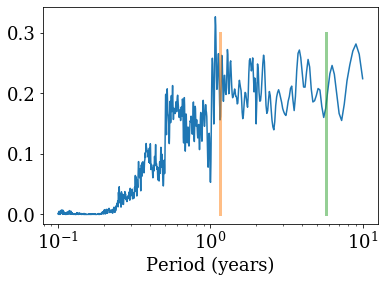

In [9]:
frequency, power = LombScargle(XX, YY).autopower(minimum_frequency=1./10, maximum_frequency=1./0.1)
plt.plot(1./frequency, power)
plt.xscale('log')
plt.plot([420/365., 420/365.], [0,0.3], c='C1', lw=3, alpha=0.5) # Dupree+(1987)
plt.plot([5.78, 5.78], [0,0.3], c='C2', lw=3, alpha=0.5) # Goldberg(1984)

plt.xlabel('Period (years)')

# Uh oh, close to that 1-yr alias...
print(1./frequency[np.argmax(power)] * 365., ' days')

In [10]:
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp,):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

In [11]:
bounds = dict(log_S0=(-0, 15), log_Q=(-15, 15), log_omega0=(-15, 15))

EPAD = 0.02 # add extra Yerror term to "account" for scatter

Q = 1.0 / np.sqrt(2.0)
w0 = .01
S0 = np.var(YY) / (w0 * Q)
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), 
                       log_omega0=np.log(w0), bounds=bounds)
kernel.freeze_parameter("log_Q") 
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), 
                       log_omega0=np.log(w0), bounds=bounds)

In [12]:
gp0 = celerite.GP(kernel, mean=np.mean(YY), fit_mean=True)
gp0.compute(XX, yerr=EE + EPAD) 

bounds = gp0.get_parameter_bounds()
initial_params = gp0.get_parameter_vector()

soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method='L-BFGS-B', bounds=bounds, args=(YY, gp0))
gp0.set_parameter_vector(soln.x)

xnew = np.linspace(XX.min(), 2022, 1500)
mu0, var0 = gp0.predict(YY, xnew, return_var=True)

In [13]:
gp0.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', 0.0),
             ('kernel:terms[0]:log_omega0', 0.6508184686729105),
             ('kernel:terms[1]:log_S0', 0.0),
             ('kernel:terms[1]:log_Q', -2.9979978011791717),
             ('kernel:terms[1]:log_omega0', -7.764262001828622),
             ('mean:value', 0.5827662356117205)])

In [14]:
# This gives us... some other period entirely right now. Huh... 2.7yrs??
print(2*np.pi/np.exp(gp0.get_parameter_dict()['kernel:terms[0]:log_omega0']))
print(2*np.pi/np.exp(gp0.get_parameter_dict()['kernel:terms[1]:log_omega0']))

3.2774267850098253
14796.398243925478


Text(0, 0.5, 'V mag')

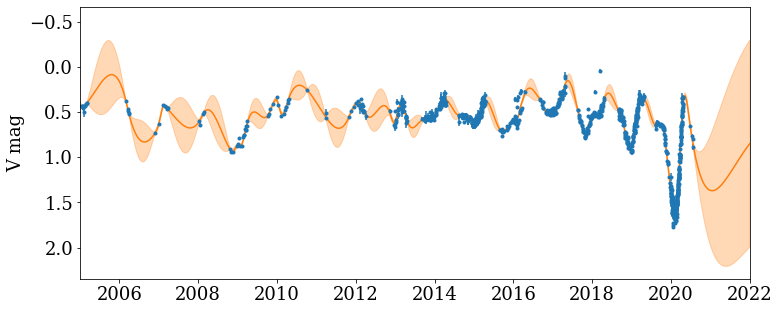

In [15]:
plt.figure(figsize=(12,5))
plt.errorbar(XX,YY, yerr=EE, linestyle='none', marker='.')

plt.plot(xnew, mu0)
plt.fill_between(xnew, mu0+np.sqrt(var0), mu0-np.sqrt(var0), color='C1', alpha=0.3,
                 edgecolor="none")
plt.gca().invert_yaxis()
plt.xlim(2005,2022)
plt.ylabel('V mag')

In [16]:
# lets switch from using celerite directly to the tutorial from exoplanet
# https://gallery.exoplanet.codes/en/latest/tutorials/stellar-variability/

In [17]:
import pymc3 as pm
import theano.tensor as tt

KNOWNPERIOD = 420./365. # rough guess from literature search...

with pm.Model() as model:

    # The mean flux of the time series (V mag in this case)
    mean = pm.Normal("mean", mu=np.mean(YY), sd=2.)

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2 * np.log(np.mean(EE)), sd=2.0)

    # A term to describe the non-periodic variability
    logSw4 = pm.Normal("logSw4", mu=np.log(np.var(YY)), sd=5.0)
    logw0 = pm.Normal("logw0", mu=np.log(2 * np.pi / 10), sd=5.0)

    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(YY)), sd=5.0)
#     BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
#     logperiod = BoundedNormal("logperiod", mu=np.log(KNOWNPERIOD), sd=5.0)
    logperiod = pm.Uniform("logperiod", lower=-1, upper=1)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = xo.distributions.UnitUniform("mix")

    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
    kernel += xo.gp.terms.RotationTerm(
        log_amp=logamp, period=period, log_Q0=logQ0, log_deltaQ=logdeltaQ, mix=mix
    )
    gp = xo.gp.GP(kernel, XX, EE ** 2 + tt.exp(logs2), mean=mean)

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=YY)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())

    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '87935' (I am process '89377')
optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]


message: Optimization terminated successfully.
logp: 883.3357865746876 -> 2661.947461050823


In [18]:
map_soln

{'mean': array(0.56356459),
 'logs2': array(-6.8714317),
 'logSw4': array(-1.72790707),
 'logw0': array(0.69677994),
 'logamp': array(-4.17754917),
 'logperiod_interval__': array(0.13542534),
 'logQ0': array(1.03346792),
 'logdeltaQ': array(3.2546865),
 'mix_logodds__': array(0.33466958),
 'logperiod': array(0.06760937),
 'mix': array(0.58289512),
 'period': array(1.06994728),
 'pred': array([0.01961484, 0.03057496, 0.07600814, ..., 0.22009772, 0.26271984,
        0.27445073])}

In [19]:
xnew = np.linspace(XX.min(), 2022, 1500)

with model:
    mu1, var1 = xo.eval_in_model(gp.predict(xnew, return_var=True), map_soln)

Text(0, 0.5, 'V mag')

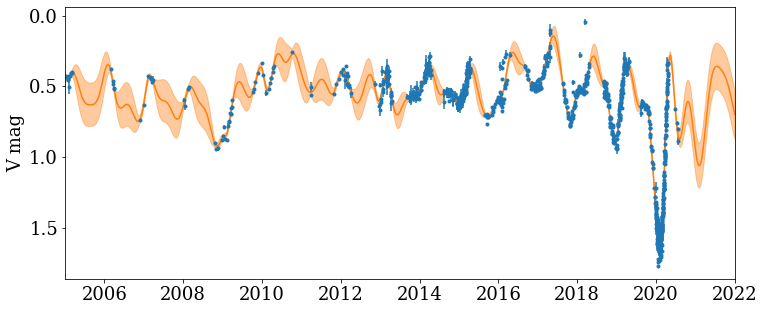

In [20]:
plt.figure(figsize=(12,5))
plt.errorbar(XX,YY, yerr=EE, linestyle='none', marker='.')

# plt.plot(XX, map_soln["pred"] + map_soln['mean'], c='C1')
plt.plot(xnew, mu1+map_soln['mean'], c='C1')
plt.fill_between(xnew, mu1-np.sqrt(var1)+map_soln['mean'], 
                 mu1+np.sqrt(var1)+map_soln['mean'], 
                 alpha=0.4, color='C1')

plt.gca().invert_yaxis()
plt.xlim(2005,2022)
plt.ylabel('V mag')

In [21]:
with model:
    trace = pm.sample(tune=500, draws=500, start=map_soln, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [01:13<00:00, 27.10draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [22]:
len(trace)

500

In [23]:
trace[1]

{'mean': 0.5470613995582871,
 'logs2': -6.754978111973681,
 'logSw4': -1.4115418968579887,
 'logw0': 0.8606704067413501,
 'logamp': -4.585316621297784,
 'logperiod_interval__': 0.16225628014571214,
 'logQ0': 1.0559424653873688,
 'logdeltaQ': 1.8668151611211121,
 'mix_logodds__': 2.7410838349143014,
 'logperiod': 0.08095061836366968,
 'mix': 0.9394078187897426,
 'period': 1.0843173498796213,
 'pred': array([0.03794015, 0.04520683, 0.09253909, ..., 0.23620233, 0.27941319,
        0.29124689])}

Text(0, 0.5, 'V mag')

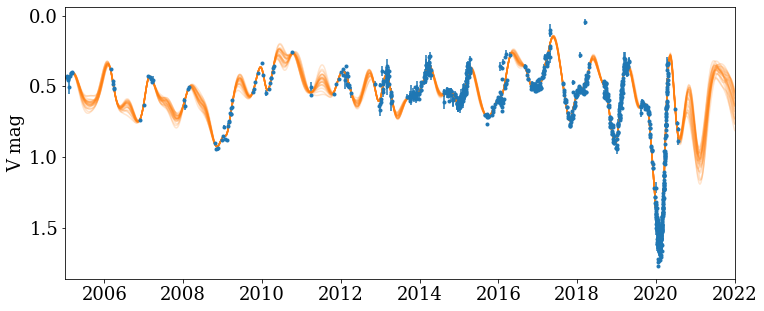

In [36]:
plt.figure(figsize=(12,5))
plt.errorbar(XX,YY, yerr=EE, linestyle='none', marker='.')

with model:
    for k in range(25):
        mu_k = xo.eval_in_model(gp.predict(xnew, return_var=False), trace[k])
        plt.plot(xnew, mu_k + trace[k]['mean'], c='C1', alpha=0.2)
    
plt.gca().invert_yaxis()
plt.xlim(2005,2022)
plt.ylabel('V mag')

In [25]:
with model:
    mu, var = xo.eval_in_model(gp.predict(xnew, return_var=True), trace[1])

Text(0, 0.5, 'V mag')

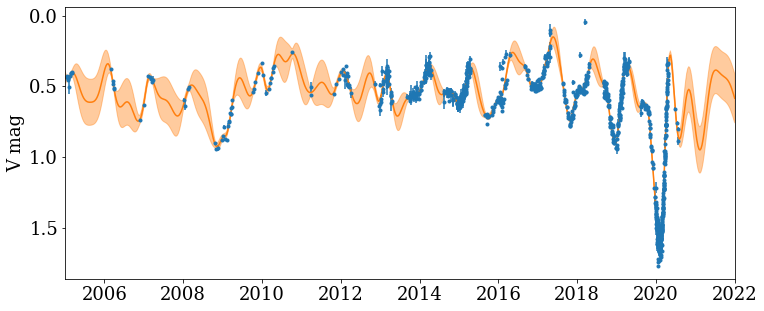

In [26]:
plt.figure(figsize=(12, 5))
plt.errorbar(XX,YY, yerr=EE, linestyle='none', marker='.')

plt.plot(xnew, mu+trace[1]['mean'], c='C1')
plt.fill_between(xnew, mu-np.sqrt(var)+trace[1]['mean'], 
                 mu+np.sqrt(var)+trace[1]['mean'], 
                 alpha=0.4, color='C1')

plt.gca().invert_yaxis()
plt.xlim(2005,2022)
plt.ylabel('V mag')

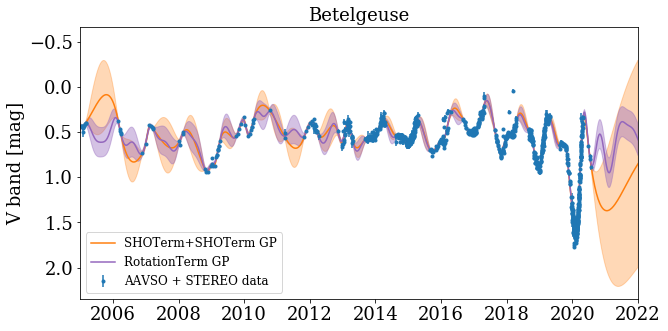

In [27]:
plt.figure(figsize=(10, 5))

plt.errorbar(XX,YY, yerr=EE, linestyle='none', marker='.', label='AAVSO + STEREO data')

plt.plot(xnew, mu0, c='C1', label='SHOTerm+SHOTerm GP')
plt.fill_between(xnew, mu0+np.sqrt(var0), mu0-np.sqrt(var0), color='C1', alpha=0.3,
                 edgecolor="none")


plt.plot(xnew, mu+trace[1]['mean'], c='C4', label='RotationTerm GP')
plt.fill_between(xnew, mu-np.sqrt(var)+trace[1]['mean'], mu+np.sqrt(var)+trace[1]['mean'], 
                 alpha=0.4, color='C4')

plt.xlim(2005,2022)
plt.gca().invert_yaxis()
plt.legend(fontsize=12,loc='lower left')
plt.ylabel('V band [mag]')
plt.title('Betelgeuse', fontsize=18)
plt.savefig('gp.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

Text(0.5, 1.0, 'Betelgeuse')

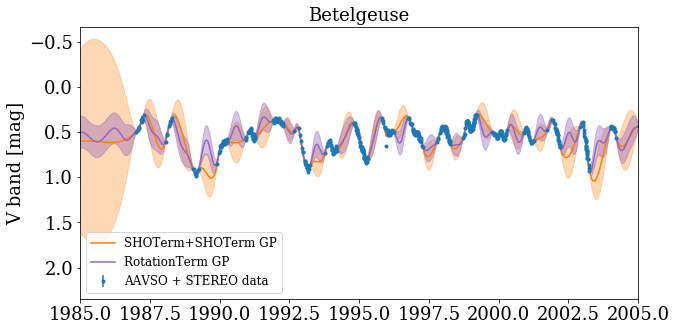

In [28]:
plt.figure(figsize=(10, 5))

plt.errorbar(XX,YY, yerr=EE, linestyle='none', marker='.', label='AAVSO + STEREO data')

plt.plot(xnew, mu0, c='C1', label='SHOTerm+SHOTerm GP')
plt.fill_between(xnew, mu0+np.sqrt(var0), mu0-np.sqrt(var0), color='C1', alpha=0.3,
                 edgecolor="none")


plt.plot(xnew, mu+trace[1]['mean'], c='C4', label='RotationTerm GP')
plt.fill_between(xnew, mu-np.sqrt(var)+trace[1]['mean'], mu+np.sqrt(var)+trace[1]['mean'], 
                 alpha=0.4, color='C4')

plt.xlim(1985,2005)
plt.gca().invert_yaxis()
plt.legend(fontsize=12,loc='lower left')
plt.ylabel('V band [mag]')
plt.title('Betelgeuse', fontsize=18)


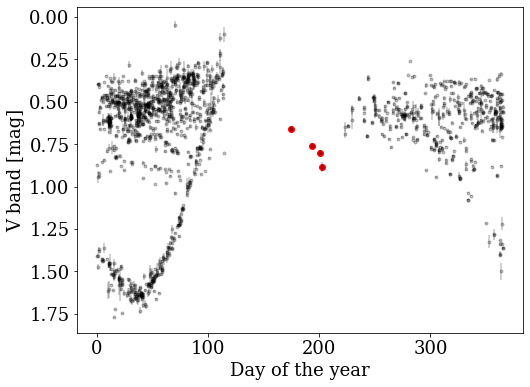

In [29]:
# just how special is that
plt.figure(figsize=(8,6))
plt.errorbar((XX % 1)*365.,YY, yerr=EE, linestyle='none', marker='.', alpha=0.24,c='k')
plt.scatter((XX[-4:] % 1)*365., YY[-4:], c='r')
plt.xlabel('Day of the year')
plt.ylabel('V band [mag]')
plt.gca().invert_yaxis()